# Create the heterogeneous mobility networks 

- Inputs: boston_stays, miami_stays, chicago_stays; shapefiles of the three cities
- Outputs: 
    - Unweighted hetero activity-based mobility networks with different thresholds (1, 10, 100) 
    - Weighted hetero activity-based mobility networks 
 
This script takes more than SIX HOURS to be finished, due to the expensive computational time in iterating over thousands of activity categories. The unweighted activity-based mobility networks with threshold=1 are so far the most useful output. The mobility networks are all directed graphs because the edges indicate the home-activity connection. 


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
from scipy.sparse import csr_matrix


Bad key text.latex.unicode in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key text.latex.preview in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/jtl/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')


In [8]:
# read files.
with open('../../data/02_intermediate/boston_stays.pickle', 'rb') as f:
    df_boston = pickle.load(f)
    

In [4]:
# read files.
with open('../../data/02_intermediate/chicago_stays.pickle', 'rb') as f:
    df_chicago = pickle.load(f)
    

In [5]:
# read files.
with open('../../data/02_intermediate/miami_stays.pickle', 'rb') as f:
    df_miami = pickle.load(f)
    

In [9]:
# create a stay dictionary
stays = {}
stays['boston'] = df_boston
stays['chicago'] = df_chicago
stays['miami'] = df_miami


In [10]:
# read the shapefile
with open('../../data/02_intermediate/boston_miami_chicago_ct_shp_dic.pickle', 'rb') as f:
    shp_dic = pickle.load(f)


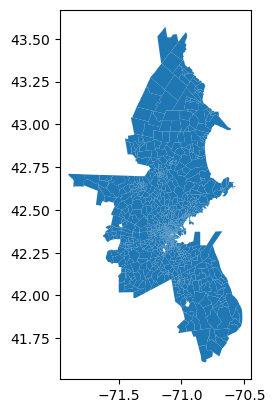

In [17]:
shp_dic['boston'].plot()
plt.show()

## Converting the Boston Stay data to heterogeneous adj metrics

In [11]:
def compute_hetero_A(df_sub, threshold, index_list):
    # Here I create the adjacency matrices
    # Network is built be connecting the home and activity locations. 
    # index_list comes from the df_shp.index; it includes 992 census tracts. 
    print('start.')
    home_place_vector = df_sub.groupby(['GEOID_home', 'GEOID']).count().iloc[:, 0]
    home_place_m = home_place_vector.unstack(level = 'GEOID')
    home_place_m.values[home_place_m.isna()] = 0
    home_place_m_weighted = home_place_m.sort_index()
    
    # create the unweighted matrix:
    home_place_m_unweighted = copy.copy(home_place_m_weighted)
    epsilon = 0.01 # use the epsilon to include the boundary case
    home_place_m_unweighted.values[home_place_m_unweighted.values < threshold - epsilon] = 0.0  
    home_place_m_unweighted.values[home_place_m_unweighted.values > threshold - epsilon] = 1.0

    # align the names of col and idx.
    col_names = set(home_place_m_unweighted.columns)
    idx_names = set(home_place_m_unweighted.index)
    
    intersection_col_names = col_names.intersection(index_list)
    intersection_idx_names = idx_names.intersection(index_list)
    
    home_place_m_weighted = home_place_m_weighted.loc[intersection_idx_names, intersection_col_names].sort_index()
    home_place_m_unweighted = home_place_m_unweighted.loc[intersection_idx_names, intersection_col_names].sort_index()
    
    print('end')
    return home_place_m_unweighted, home_place_m_weighted
    

In [18]:
# test an example
activity = 'Office'
threshold = 1.0
index_list = list(shp_dic['chicago'].index)
df_sub = stays['chicago'].loc[stays['chicago'].cat == activity, :]
home_place_m_unweighted, home_place_m_weighted = compute_hetero_A(df_sub, threshold, index_list)
home_place_m_unweighted.sum().sum()
home_place_m_unweighted


start.
end


GEOID,17031842900,17197881009,17097863601,17031071100,17197880414,17197883214,17031242400,17031230900,17031010400,17031838600,...,17089852808,17111871307,17043846405,17031190800,17031801601,17031806102,17031430500,17089850105,17031805001,17031220300
GEOID_home,,,,,,,,,,,,,,,,,,,,,
17031010100,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17031010201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17031010202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17031010300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17031010400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197884004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17197884005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17197884006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Compute the heterogeneous mobility networks regarding activity categories
# It takes more than 5 hours
# It takes too long - 100.0 & miami is NOT complete!
A_home_activity_weighted_dic = {}
A_home_activity_unweighted_dic = {}

city_list = ['boston', 'chicago', 'miami']
threshold_list = [1.0, 10.0, 100.0]

# computation: 3 * 3 * 600 (!)
for city in city_list:
    print(city)
    A_home_activity_weighted_dic[city] = {}
    A_home_activity_unweighted_dic[city] = {}
    
    # create the index list.
    index_list = list(shp_dic[city].index)
    activity_categories = list(np.unique(stays[city].cat))
    
    for threshold in threshold_list:
        print(threshold)
        A_home_activity_unweighted_dic[city][threshold] = {}
        for activity in activity_categories:
            df_sub = stays[city].loc[stays[city].cat == activity, :]
            home_place_m_unweighted, home_place_m_weighted = compute_hetero_A(df_sub, threshold, index_list)

            ###
            A_home_activity_weighted_dic[city][activity] = home_place_m_weighted
            A_home_activity_unweighted_dic[city][threshold][activity] = home_place_m_unweighted


boston
1.0
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end

start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end

start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end

start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end

start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end

start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end

start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
10.0
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start.
end
start

KeyboardInterrupt: 

In [22]:
# compute the total count network
city_list = ['boston', 'chicago', 'miami']
threshold_list = [1.0, 10.0, 100.0]
A_home_total_weighted_dic = {}
A_home_total_unweighted_dic = {}

for city in city_list:
    print(city)
    A_home_total_weighted_dic[city] = {}
    A_home_total_unweighted_dic[city] = {}
    index_list = list(shp_dic[city].index)   
    
    for threshold in threshold_list:
        print(threshold)
        A_home_total_unweighted_dic[city][threshold] = {}

        df_sub = copy.copy(stays[city])
        home_place_m_unweighted, home_place_m_weighted = compute_hetero_A(df_sub, threshold, index_list)

        ###
        A_home_total_weighted_dic[city]['total'] = home_place_m_weighted
        A_home_total_unweighted_dic[city][threshold]['total'] = home_place_m_unweighted


boston
1.0


KeyboardInterrupt: 

In [3]:
# # read files
# with open("../../data/03_processed/A_home_activity_three_cities_unweighted_dic.pickle", 'rb') as f:
#     A_home_activity_unweighted_dic = pickle.load(f)

# with open("../../data/03_processed/A_home_activity_three_cities_weighted_dic.pickle", 'rb') as f:
#     A_home_activity_weighted_dic = pickle.load(f)


In [4]:
# # need to create A_home_activity_unweighted_dic['total'][1.0], A_home_activity_unweighted_dic['total'][10.0]
# # need to create A_home_activity_weighted_dic['total'][1.0], A_home_activity_weighted_dic['total'][10.0]

# A_home_activity_unweighted_total = pd.concat([A_home_activity_unweighted_dic['boston'][1.0],
#            A_home_activity_unweighted_dic['miami'][1.0], 
#            A_home_activity_unweighted_dic['chicago'][1.0]], axis = 0)


KeyboardInterrupt: 

In [5]:
A_home_activity_unweighted_dic['boston'][1.0]

{'ATM': GEOID        25009211402  25017357500  25025101102  25017374200  25025020301  \
 GEOID_home                                                                     
 25009201100          0.0          0.0          0.0          0.0          0.0   
 25009202101          0.0          0.0          0.0          0.0          0.0   
 25009202102          0.0          0.0          0.0          0.0          0.0   
 25009202200          0.0          0.0          0.0          0.0          0.0   
 25009203100          1.0          0.0          0.0          0.0          0.0   
 ...                  ...          ...          ...          ...          ...   
 33017085000          0.0          0.0          0.0          0.0          0.0   
 33017086000          0.0          0.0          0.0          0.0          0.0   
 33017087000          0.0          0.0          0.0          0.0          0.0   
 33017088000          0.0          0.0          0.0          0.0          0.0   
 33017088500         

# Save

In [23]:
with open("../../data/03_processed/A_home_activity_three_cities_unweighted_dic.pickle", 'wb') as f:
    pickle.dump(A_home_activity_unweighted_dic, f)


In [24]:
with open("../../data/03_processed/A_home_activity_three_cities_weighted_dic.pickle", 'wb') as f:
    pickle.dump(A_home_activity_weighted_dic, f)


In [ ]:
# with open("../../data/03_processed/A_home_total_three_cities_weighted_dic.pickle", 'wb') as f:
#     pickle.dump(A_home_total_weighted_dic, f)

# with open("../../data/03_processed/A_home_total_three_cities_unweighted_dic.pickle", 'wb') as f:
#     pickle.dump(A_home_total_unweighted_dic, f)
    